# Flow Cytometry Analysis
**Brandon Holt**

This is first just going through the steps Nick outlined to plot the cytometry results and practice gating. 

I chose to plot the sample of my strain that worked the best (RPT5-2, 1:10k dilution, with β-estrodiol).

My analysis of my two strains (RPT5-1 and RPT5-2) are at the bottom.

In [1]:
import pandas as pd
import FlowCytometryTools as fct
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


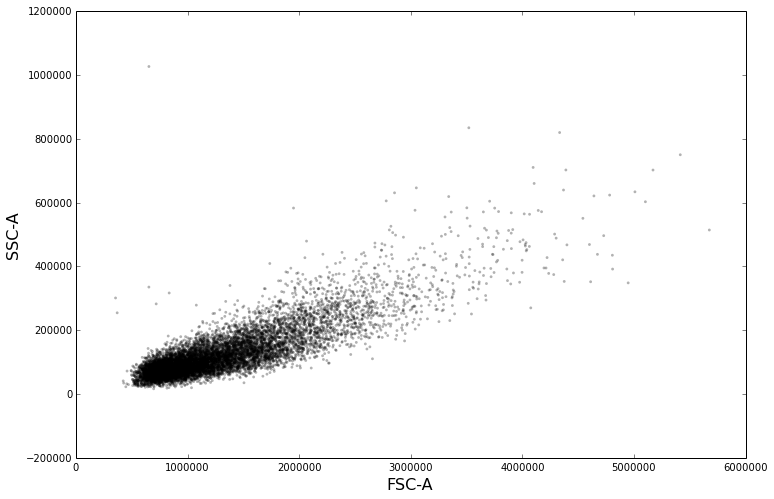

In [2]:
sample = fct.FCMeasurement(ID='RPT5-2-A', datafile='/labw16/plate1/Sample D03.fcs')
sample.plot(('FSC-A', 'SSC-A'), kind='scatter', color='black', alpha=0.3, s=8)

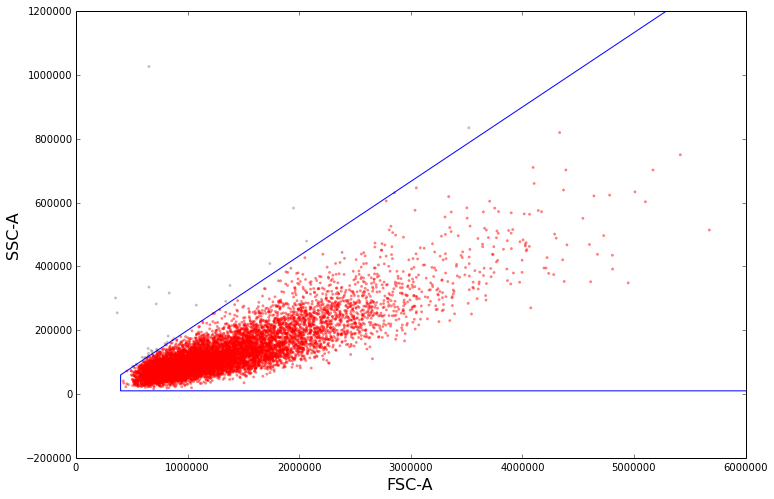

In [3]:
# A 2D Polygon Gate - just a set of vertices on the same attributes as above
yeast_gate = fct.PolyGate([(4e5, 1e4), (1e7, 1e4), (1e7, 23e5), (4e5, 6e4)], 
                          ('FSC-A', 'SSC-A'), 
                          region='in', 
                          name='poly gate')

# We can subset to the events within the gate, or to those outside of it
yeast_sample = sample.gate(yeast_gate)
notyeast_sample = sample.gate(~yeast_gate)

# A visualization of our new yeast_gate
yeast_sample.plot(('FSC-A', 'SSC-A'), gates=[yeast_gate], kind='scatter', color='red', alpha=0.5, s=8);
notyeast_sample.plot(('FSC-A', 'SSC-A'), kind='scatter', color='gray', alpha=0.5, s=8);

## Doublet discrimination

(0, 12000000.0)

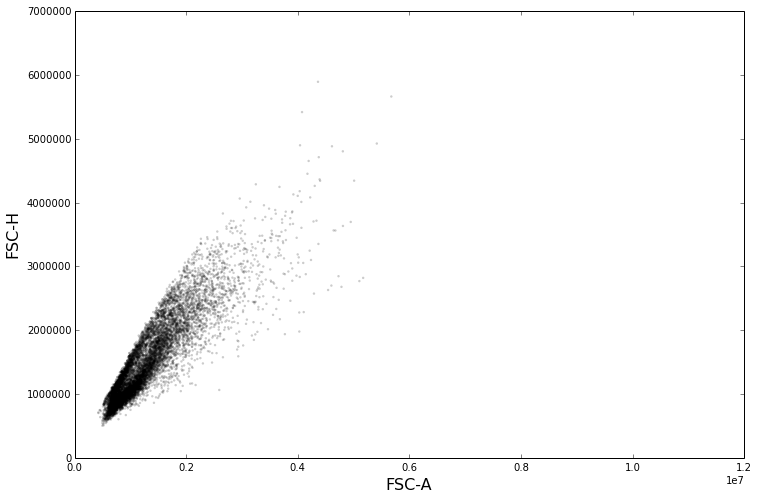

In [4]:
yeast_sample.plot(('FSC-A', 'FSC-H'), kind='scatter', color='black', alpha=0.2, s=6)
plt.ylim((0, 7e6))
plt.xlim((0, 1.2e7))

(0, 12000000.0)

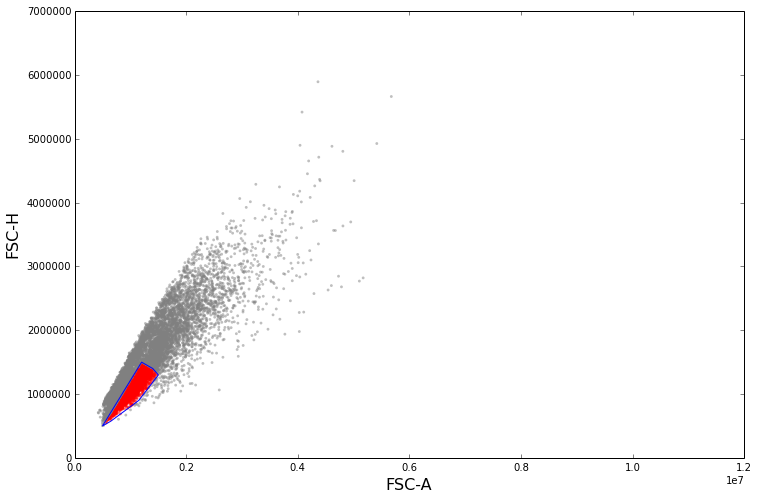

In [5]:
singlet_gate = fct.PolyGate([(6.5e5, 5.75e5), (1.15e6, 9e5), (1.5e6,1.3e6), (1.4e6, 1.4e6), (1.2e6, 1.5e6), (5e5, 5e5)], 
                            ('FSC-A', 'FSC-H'), 
                            region='in', 
                            name='singlets')

singlets_sample = yeast_sample.gate(singlet_gate)
notsinglets_sample = yeast_sample.gate(~singlet_gate)

singlets_sample.plot(('FSC-A', 'FSC-H'), gates=[singlet_gate], kind='scatter', color='red', alpha=0.5, s=8);
notsinglets_sample.plot(('FSC-A', 'FSC-H'), kind='scatter', color='gray', alpha=0.5, s=8);
plt.ylim((0, 7e6))
plt.xlim((0, 1.2e7))

Number of yeast cells: 10099
Number of single cells: 3138
Mean: 876.756532823
Median: 876.0
Std Dev: 430.229631545


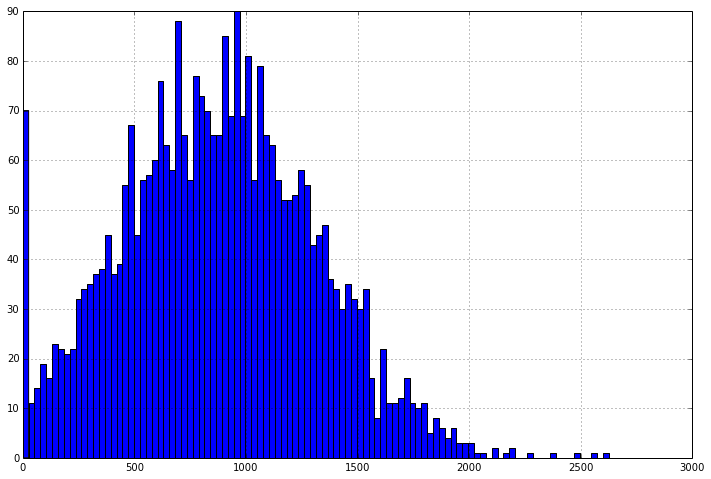

In [6]:
print 'Number of yeast cells:', yeast_sample.counts
print 'Number of single cells:', singlets_sample.counts

fl1a = singlets_sample['FL1-A']
print 'Mean:', fl1a.mean()
print 'Median:', fl1a.median()
print 'Std Dev:', fl1a.std()
fl1a.hist(bins=100)

In [7]:
# '$VOL' key stores the approximate volume taken up by the Accuri C6 in nanoliters
# microliters (ul) = nanoliters / 1000
ul = float(yeast_sample.meta['$VOL']) / 1000
print ul

6.108


# Analysis
To determine if the KillSwitches worked, we're comparing concentrations against the negative control.

In [8]:
# You can read in an entire 'plate' of FCS files at once, but you need to
# use a custom name parser
# The way that FCS files are parsed by default isn't compatible with
# the way C6 FCS files are named, so need a custom parser.
# Converts e.g. '/full/path/to/Sample C04.fcs' to 'C4'
import os
def parse_c6fcs(path):
    filename = os.path.basename(path)
    key_str = os.path.splitext(filename.strip('Sample '))[0]
    row = key_str[0]
    col = int(key_str[1:])
    return '{}{:01d}'.format(row, col)

# Note that I have placed all of the files in the /labw16/ folder, which anyone can read
plate1 = fct.FCPlate.from_dir(ID='plate1', path='/labw16/plate1/', parser=parse_c6fcs, position_mapper='name')

yeast_counts = plate1.gate(yeast_gate).counts()
yeast_counts

,1,2,3,4,5,6,7,8,9,10,11,12
A,10615,10162,10575,10548,10494,10504,10570,10531,78,NaN,NaN,NaN
B,10637,10566,10544,10506,10538,10530,10486,10403,513,NaN,NaN,NaN
C,10332,10326,10202,10254,10192,10325,10245,10117,122,NaN,NaN,NaN
D,10140,10093,10099,10077,10150,10122,10142,10091,18,NaN,NaN,NaN
E,10309,10294,10189,10113,10145,10172,10219,10144,32,NaN,NaN,NaN
F,10123,10096,10084,10062,10052,10040,10051,10196,132,NaN,NaN,NaN
G,10111,10098,10142,10149,10173,10134,10017,10088,1149,NaN,NaN,NaN
H,10249,10194,10181,10190,10167,10157,10105,10165,72,NaN,NaN,NaN


In [9]:
vol_list = plate1.get_measurement_metadata('$VOL')
concs = yeast_counts.copy()
for colname, value in vol_list.iteritems():
    row = colname[0]
    column = int(colname[1:])
    # Cytometer volume is in units of nanoliters
    ul_cyt = float(value) / 1000.0
    # Diluted sample 1:10 before reading
    ul = ul_cyt * 10
    concs.loc[row][column] = yeast_counts.loc[row][column] / ul
concs.columns = ['Strain {}'.format(col) for col in concs.columns]

concs

,Strain 1,Strain 2,Strain 3,Strain 4,Strain 5,Strain 6,Strain 7,Strain 8,Strain 9,Strain 10,Strain 11,Strain 12
A,486.480293,465.719523,440.441483,403.211009,400.840336,481.834862,606.077982,483.739090,0.155462,NaN,NaN,NaN
B,488.159706,484.901331,483.447960,482.147774,482.509158,439.115930,601.951780,595.477962,1.024893,NaN,NaN,NaN
C,278.115747,295.958727,274.542519,261.115355,291.867125,278.827977,276.518219,289.636416,0.243742,NaN,NaN,NaN
D,201.992032,256.688708,165.340537,230.700549,210.493571,221.052632,290.601719,220.231340,0.035964,NaN,NaN,NaN
E,472.673086,472.418541,576.953567,463.473877,465.366972,584.261918,425.969154,387.619412,0.063807,NaN,NaN,NaN
F,422.319566,355.743481,355.822159,271.652268,256.101911,219.213974,200.538707,424.302955,0.263731,NaN,NaN,NaN
G,243.814806,289.672978,202.354350,202.372881,245.309863,211.081025,169.779661,231.376147,2.290396,NaN,NaN,NaN
H,261.187564,259.455332,212.104167,245.957036,211.856637,221.671759,220.874317,222.234368,0.143529,NaN,NaN,NaN


Select just my strains (RPT5 1 & 2) and create a new dataframe with columns and labels to help plot it.

In [10]:
subset = concs.iloc[:,[0,3,4]]
subset.columns = ['Negative', 'RPT5-2', 'RPT5-1']
d = subset.T
d.columns = ['r100_n_1', 'r100_B_1', 'r10k_n_1', 'r10k_B_1', 'r100_n_2', 'r100_B_2', 'r10k_n_2', 'r10k_B_2']

c100_n = pd.DataFrame({'mean': d[['r100_n_1', 'r100_n_2']].mean(axis=1), 'stdev': d[['r100_n_1', 'r100_n_2']].std(axis=1), 'dilution': '1:100', 'condition': '-'})
c100_B = pd.DataFrame({'mean': d[['r100_B_1', 'r100_B_2']].mean(axis=1), 'stdev': d[['r100_B_1', 'r100_B_2']].std(axis=1), 'dilution': '1:100', 'condition': 'β'})
c10k_n = pd.DataFrame({'mean': d[['r10k_n_1', 'r10k_n_2']].mean(axis=1), 'stdev': d[['r10k_n_1', 'r10k_n_2']].std(axis=1), 'dilution': '1:10k', 'condition': '-'})
c10k_B = pd.DataFrame({'mean': d[['r10k_B_1', 'r10k_B_2']].mean(axis=1), 'stdev': d[['r10k_B_1', 'r10k_B_2']].std(axis=1), 'dilution': '1:10k', 'condition': 'β'})
df = pd.concat([c100_n, c100_B, c10k_n, c10k_B])
df.index.name = 'strain'
df.reset_index(inplace=True)
df = df.sort_values(['strain', 'dilution', 'condition'])
df['group'] = df['strain'] + ' | ' + df['condition'] + ' | ' + df['dilution']
df

,strain,condition,dilution,mean,stdev,group
0,Negative,-,1:100,479.576690,9.763170,Negative | - | 1:100
3,Negative,β,1:100,455.239636,46.556010,Negative | β | 1:100
6,Negative,-,1:10k,260.965276,24.254428,Negative | - | 1:10k
9,Negative,β,1:10k,231.589798,41.857562,Negative | β | 1:10k
2,RPT5-1,-,1:100,433.103654,45.627222,RPT5-1 | - | 1:100
5,RPT5-1,β,1:100,369.305534,160.094099,RPT5-1 | β | 1:100
8,RPT5-1,-,1:10k,268.588494,32.920956,RPT5-1 | - | 1:10k
11,RPT5-1,β,1:10k,211.175104,0.963833,RPT5-1 | β | 1:10k
1,RPT5-2,-,1:100,433.342443,42.612283,RPT5-2 | - | 1:100
4,RPT5-2,β,1:100,376.900021,148.842800,RPT5-2 | β | 1:100


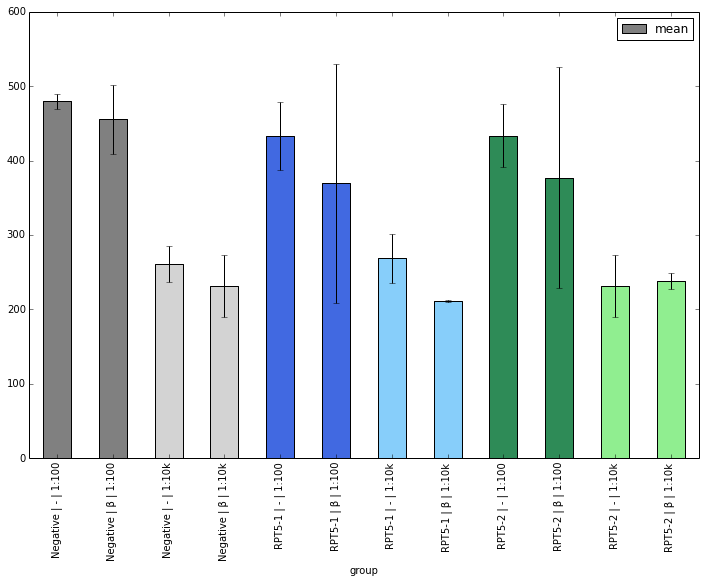

In [11]:
colors = pd.Series(['gray','gray','lightgray','lightgray','royalblue','royalblue','lightskyblue','lightskyblue','seagreen','seagreen','lightgreen','lightgreen'])
df.plot.bar(x='group', y='mean', yerr='stdev', color=colors)

This plot shows the concentrations of each of the experiments, grouped by strain ('Negative' is the control (gray), 'RPT5-1' (blue) and 'RPT5-2' (green) are my strains). Then each has two different dilutions, '1:100' and '1:10000' (lighter color). And then for each, we have two bars: one without β-estrodiol and one with (on the right).

The results are not very good. It looks like there is much more error in the measurements than difference for the most part. The only one where there is a *significant* difference is RPT5-1 at '1:10k'. In that case, there is a small, but significant, lowering of the concentration for the one *with* β-estrodiol. But I would hestitate to claim that this indicates a working "Kill Switch". Hopefully others were able to get ones that worked better!